# MNIST 손글씨 분류기 - Tensorflow, MLflow

##

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import mlflow
import mlflow.tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Class:  5


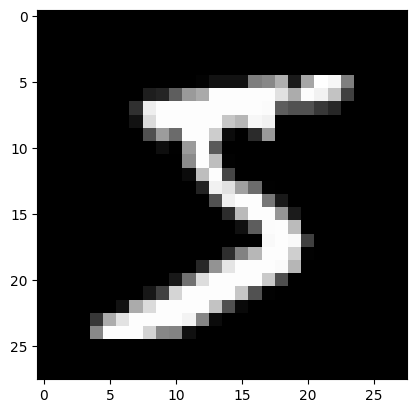

In [3]:
plt.imshow(x_train[0], cmap='gray')
print("Class: ", y_train[0])

In [4]:
x_train = x_train.reshape(
    x_train.shape[0], x_train.shape[1], x_train.shape[2], 1
)

x_test = x_test.reshape(
    x_test.shape[0], x_test.shape[1], x_test.shape[2], 1
)

In [5]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [6]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [7]:
print("Shapes")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_train: {x_test.shape}")

Shapes
x_train: (60000, 28, 28, 1), y_train: (60000, 10)
x_test: (10000, 28, 28, 1), y_train: (10000, 28, 28, 1)


### MLflow 실행 - 학습 및 평가

In [8]:
model = Sequential()
model.add(
    Conv2D(
        filters=16,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="relu",
        input_shape=(28, 28, 1),
    )
)
model.add(
    Conv2D(
        filters=8,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="relu",
        input_shape=(28, 28, 1),
    )
)
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

D:\강의자료\MLflow\py311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                     ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                  │ (None, 14, 14, 16)       │           160 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)                │ (None, 7, 7, 8)          │         1,160 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ flatten (Flatten)                │ (None, 392)              │             0 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                    │ (None, 30)               │        11,790 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_1 (Dense)                  │ (None, 20)               │           620 │
├──────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                  │ (None, 10)               │           210 │
└──────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 13,940 (54.45 KB)

 Trainable params: 13,940 (54.45 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
mlflow.set_experiment("TF_Keras_MNIST")

with mlflow.start_run():
    mlflow.tensorflow.autolog()
    model.fit(x_train, y_train, batch_size=256, epochs=10)
    preds = model.predict(x_test)
    preds = np.round(preds)
    eval_acc = model.evaluate(x_test, preds)[1]
    auc_score = roc_auc_score(y_test, preds)
    print(f"Eval Accuracy: {eval_acc}")
    print(f"AUC Score: {auc_score}")
    mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
    mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)
mlflow.end_run()

2024/04/01 10:33:58 INFO mlflow.tracking.fluent: Experiment with name 'TF_Keras_MNIST' does not exist. Creating a new experiment.
2024/04/01 10:33:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Epoch 1/10
225/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4109 - loss: 3.0896

2024/04/01 10:34:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4219 - loss: 3.0095
Epoch 2/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9191 - loss: 0.2699

2024/04/01 10:34:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9193 - loss: 0.2693
Epoch 3/10
223/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9525 - loss: 0.1586

2024/04/01 10:34:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9527 - loss: 0.1581
Epoch 4/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9660 - loss: 0.1176

2024/04/01 10:34:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9660 - loss: 0.1175
Epoch 5/10
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9718 - loss: 0.0917

2024/04/01 10:34:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9718 - loss: 0.0917
Epoch 6/10
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9767 - loss: 0.0753

2024/04/01 10:34:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9767 - loss: 0.0753
Epoch 7/10
230/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9806 - loss: 0.0643

2024/04/01 10:34:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9806 - loss: 0.0643
Epoch 8/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9835 - loss: 0.0542

2024/04/01 10:34:11 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9835 - loss: 0.0542
Epoch 9/10
229/235 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9843 - loss: 0.0521

2024/04/01 10:34:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9843 - loss: 0.0521
Epoch 10/10
227/235 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9857 - loss: 0.0466

2024/04/01 10:34:14 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9857 - loss: 0.0466
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


2024/04/01 10:34:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9964 - loss: 0.0233
Eval Accuracy: 0.9966999888420105
AUC Score: 0.9836706911106804


### MLflow UI - 실행 체크

### MLflow 모델 적재

In [32]:
# loaded_model = mlflow.tensorflow.load_model("runs:/<run_id>/model")
loaded_model = mlflow.tensorflow.load_model(
    "runs:/4d424402ff9348d280ff723e78090afc/model"
)

In [34]:
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)
preds = loaded_model.predict(x_test)
preds = np.round(preds)
eval_auc = roc_auc_score(y_test, preds)
print(f"Eval Loss: {eval_loss}")
print(f"Eval Accuracy: {eval_acc}")
print(f"Eval AUC: {eval_auc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9716 - loss: 0.1141
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Eval Loss: 0.08972299844026566
Eval Accuracy: 0.9768999814987183
Eval AUC: 0.986657640582421
